<a href="https://www.kaggle.com/code/nurnayeem422/retail-category-classification?scriptVersionId=273156509" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

# Dataset paths
dataset_root = "/kaggle/input/retail-product-category-classification"

In [2]:
train_dir = os.path.join(dataset_root, "train/train")

Found 42000 images.


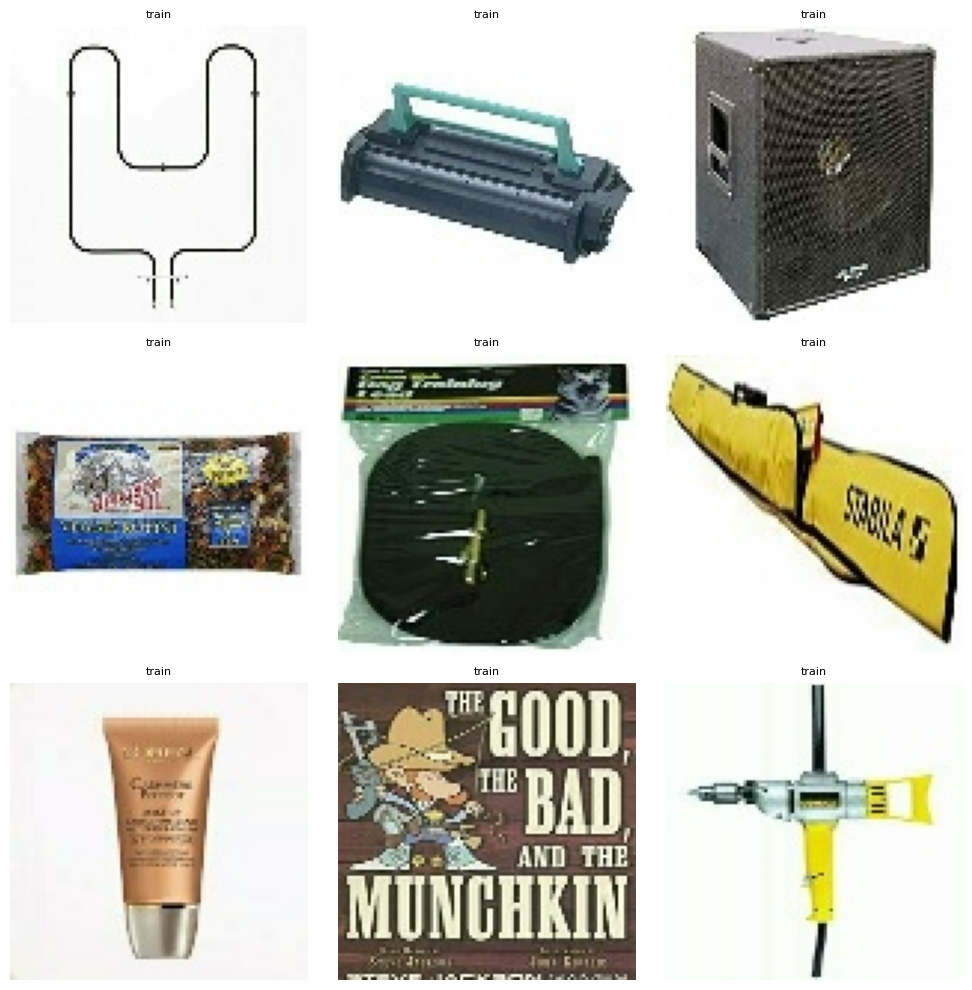

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your training directory
train_dir = os.path.join(dataset_root, "train/train")

# Collect all image paths (including those inside subfolders)
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")

# Select a few random images (e.g., 9)
num_samples = 9
sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

# Plot the images
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_paths):
    img = mpimg.imread(img_path)
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(os.path.dirname(img_path)), fontsize=8)

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle


# --- 1. Configuration and Data Load ---
# Paths and Constants
CSV_PATH = '/kaggle/input/retail-product-category-classification/train.csv'
IMAGE_DIR = train_dir # Folder containing all 42000 images
IMAGE_SIZE = (100, 100)      # Your specified image size
BATCH_SIZE = 32
RANDOM_STATE = 42
EPOCHS = 30                  # Recommended starting epochs for initial training

# Text Constants
MAX_WORDS = 10000            # Vocabulary size for the tokenizer
MAX_LEN = 50                 # Max length of text sequence
EMBEDDING_DIM = 100          # Size of the embedding vector

print("--- Configuration Loaded ---")
print(f"Image Size: {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]} | Batch Size: {BATCH_SIZE}")


# Load and prepare data (using mock data if CSV is not found)
try:
    df = pd.read_csv(CSV_PATH)
    # Ensure all required columns exist and handle NaNs
    df['title'] = df['title'].fillna('')
    df['description'] = df['description'].fillna('')
except FileNotFoundError:
    print(f"Warning: CSV file not found at {CSV_PATH}. Using mock data for structure.")
    num_samples = 42000
    df = pd.DataFrame({
        'ImgId': [f'ID_{i:05d}' for i in range(num_samples)],
        'title': [f'Product {i} title'] * num_samples,
        'description': [f'Detailed description of product {i} in retail category'] * num_samples,
        'categories': np.random.choice([f'Category_{j}' for j in range(21)], size=num_samples)
    })

# Prepare features
df['filename'] = df['ImgId'].astype(str) + '.jpg'
df['text_data'] = df['title'] + ' ' + df['description']
NUM_CLASSES = len(df['categories'].unique())

# Split data (80% train, 10% validation, 10% test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['categories'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df['categories'])

print(f"Data Split: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")










2025-11-03 14:49:11.869823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762181352.052918      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762181352.114624      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Configuration Loaded ---
Image Size: 100x100 | Batch Size: 32
Data Split: Train=36983, Validation=4623, Test=4623


In [5]:
# --- 2. Text Preprocessing and Label Encoding ---
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
# Only fit tokenizer on training data to prevent data leakage
tokenizer.fit_on_texts(train_df['text_data']) 

def preprocess_text(data):
    sequences = tokenizer.texts_to_sequences(data['text_data'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    # Must return NumPy array
    return np.array(padded_sequences, dtype='int32')

# Preprocess all text data upfront
train_text_seq = preprocess_text(train_df)
val_text_seq = preprocess_text(val_df)
test_text_seq = preprocess_text(test_df)

# Label Encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_df['categories']) # Fit on training categories

def encode_labels(data):
    integer_encoded = label_encoder.transform(data['categories'])
    return tf.keras.utils.to_categorical(integer_encoded, num_classes=NUM_CLASSES)

train_labels = encode_labels(train_df)
val_labels = encode_labels(val_df)
test_labels = encode_labels(test_df)

CLASS_NAMES = label_encoder.classes_
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 21


In [6]:
# --- 3. Custom Multimodal Data Generator ---
class MultimodalGenerator(tf.keras.utils.Sequence):
    """
    Keras Sequence for loading images dynamically and combining with pre-processed text.
    """
    def __init__(self, df, text_sequences, image_dir, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.text_sequences = text_sequences
        self.image_dir = image_dir
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X_img, X_text, y = self.__data_generation(indexes)
        
        # FIX: Change the input feature container from a list to a tuple '(...)'
        # This matches the expected structure defined in OUTPUT_SIGNATURE: ((Tensor, Tensor), Tensor)
        return (tf.convert_to_tensor(X_img, dtype=tf.float32), 
                tf.convert_to_tensor(X_text, dtype=tf.int32)), \
               tf.convert_to_tensor(y, dtype=tf.float32)


    def __data_generation(self, indexes):
        X_img = np.empty((self.batch_size, *self.image_size, 3), dtype='float32')
        X_text = np.empty((self.batch_size, MAX_LEN), dtype='int32')
        y = np.empty((self.batch_size, NUM_CLASSES), dtype='float32')

        for i, original_index in enumerate(indexes):
            # Load image (100x100)
            filename = self.df.loc[original_index]['filename']
            img_path = os.path.join(self.image_dir, filename)
            
            try:
                img = tf.keras.utils.load_img(img_path, target_size=self.image_size)
                img_array = tf.keras.utils.img_to_array(img) / 255.0 # Rescale
            except:
                # Fallback for missing/corrupted images (essential for large datasets)
                img_array = np.zeros((*self.image_size, 3), dtype='float32')
                
            X_img[i,] = img_array

            # Get text sequence
            X_text[i,] = self.text_sequences[original_index] 
            
            # Get label
            y[i] = self.labels[original_index]

        return X_img, X_text, y


# Instantiate the generators
train_generator = MultimodalGenerator(train_df, train_text_seq, IMAGE_DIR, train_labels, shuffle=True)
val_generator = MultimodalGenerator(val_df, val_text_seq, IMAGE_DIR, val_labels, shuffle=False)
test_generator = MultimodalGenerator(test_df, test_text_seq, IMAGE_DIR, test_labels, shuffle=False)



In [7]:
# --- 4. Dataset Wrapper to resolve TypeError ---

# Define the expected output structure and types for the generator
OUTPUT_SIGNATURE = (
    # First element: Tuple of two inputs (Image Tensor, Text Tensor)
    (
        tf.TensorSpec(shape=(None, *IMAGE_SIZE, 3), dtype=tf.float32), # Image Input (None = Batch Size)
        tf.TensorSpec(shape=(None, MAX_LEN), dtype=tf.int32)           # Text Input
    ),
    # Second element: Label Tensor
    tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)         # Label Output
)

# Wrapper function to iterate over the Keras Sequence
def multimodal_data_generator(keras_sequence):
    """Generator function required by tf.data.Dataset.from_generator."""
    for i in range(len(keras_sequence)):
        yield keras_sequence[i]

# Create the tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_generator(
    lambda: multimodal_data_generator(train_generator),
    output_signature=OUTPUT_SIGNATURE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: multimodal_data_generator(val_generator),
    output_signature=OUTPUT_SIGNATURE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: multimodal_data_generator(test_generator),
    output_signature=OUTPUT_SIGNATURE
)

print("Dataset wrapping complete. Ready for model building.")

# --- Plotting Functions ---

def plot_training_history(history):
    """Plots training and validation loss and accuracy curves."""
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve (Training vs. Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve (Training vs. Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """Plots the visual confusion matrix."""
    plt.figure(figsize=(14, 12))
    # Use seaborn for a visually appealing heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Visual Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(y_true, y_pred_probs, class_names, num_classes):
    """Computes and plots the Multi-Class ROC curve using the One-vs-Rest approach."""
    # Binarize the true labels from class indices
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area (overall performance)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area (average per-class performance)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        # Use numpy.interp as it's standard in numpy
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot Micro and Macro Averages
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    # Plot first few individual classes for visibility
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(min(5, num_classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True)
    plt.show()

Dataset wrapping complete. Ready for model building.


I0000 00:00:1762181368.571890      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# --- 5. Build, Compile, and Train Model ---

# Image Branch (CNN - ResNet50)
def build_image_model():
    image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
    
    # ResNet50 accepts 100x100 input
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input, pooling=None)
    
    # Freeze the base model layers (Transfer Learning)
    for layer in base_model.layers:
        layer.trainable = False
        
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', name='image_dense')(x)
    
    return Model(inputs=image_input, outputs=x, name='Image_Branch')

# Text Branch (Embedding + LSTM)
def build_text_model():
    text_input = Input(shape=(MAX_LEN,), name='text_input')
    
    x = Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
    x = LSTM(128)(x)
    x = Dense(128, activation='relu', name='text_dense')(x)
    
    return Model(inputs=text_input, outputs=x, name='Text_Branch')

# Combine the models
image_model = build_image_model()
text_model = build_text_model()

combined = concatenate([image_model.output, text_model.output])

# Final classifier layers
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(NUM_CLASSES, activation='softmax')(z) # 21 classes output

multimodal_model = Model(inputs=[image_model.input, text_model.input], outputs=z)

# Compile
multimodal_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

print("\n--- Model Summary ---")
multimodal_model.summary()

# --- Train the Model ---
print("\n--- Starting Training ---")
# Now using the tf.data.Dataset objects
history = multimodal_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    verbose=1
)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 25,349,973 (96.70 MB)

 Trainable params: 1,762,261 (6.72 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Starting Training ---
Epoch 1/30


I0000 00:00:1762181384.127904      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1155/Unknown 247s 202ms/step - accuracy: 0.1107 - loss: 2.7666

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1155/1155 ━━━━━━━━━━━━━━━━━━━━ 278s 229ms/step - accuracy: 0.1107 - loss: 2.7664 - val_accuracy: 0.2463 - val_loss: 2.1482
Epoch 2/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.2922 - loss: 1.9831 - val_accuracy: 0.5302 - val_loss: 1.3724
Epoch 3/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.5949 - loss: 1.2245 - val_accuracy: 0.6562 - val_loss: 1.1228
Epoch 4/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7208 - loss: 0.8802 - val_accuracy: 0.7051 - val_loss: 1.0125
Epoch 5/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7864 - loss: 0.6800 - val_accuracy: 0.7148 - val_loss: 1.0508
Epoch 6/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.8305 - loss: 0.5437 - val_accuracy: 0.7385 - val_loss: 1.0858
Epoch 7/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.8635 - loss: 0.4483 - val_accuracy: 0.7489 - val_loss: 1.1170
Epoch 8/30
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.8929 - loss: 0.


--- Evaluating on Test Set ---
144/144 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.7405 - loss: 2.8052

Overall Test Accuracy: 74.63%
Overall Test Loss: 2.7755
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step

--- Plotting Training History (Accuracy and Loss Curve) ---


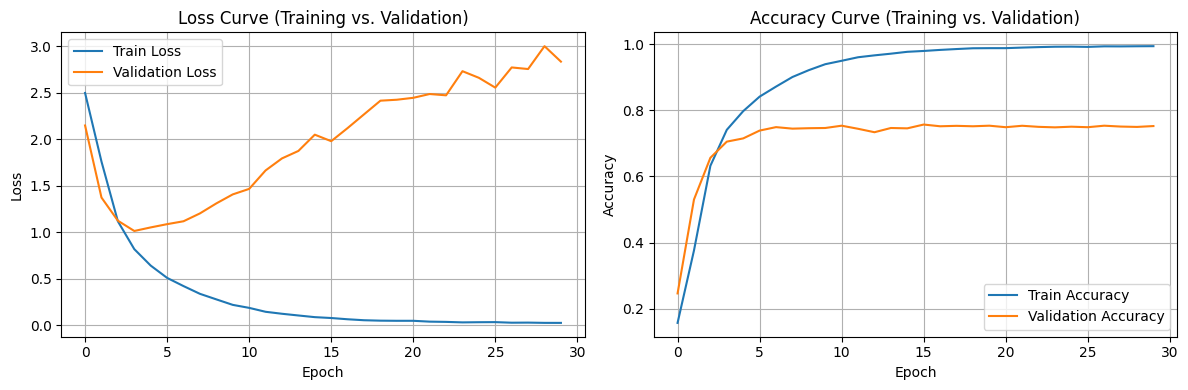


--- Classification Report (Per-Class Metrics) ---
                           precision    recall  f1-score   support

               All Beauty       0.59      0.59      0.59       220
          All Electronics       0.63      0.54      0.58       220
               Appliances       0.91      0.89      0.90       219
    Arts, Crafts & Sewing       0.78      0.66      0.72       222
               Automotive       0.71      0.74      0.73       219
                     Baby       0.65      0.74      0.69       220
            Baby Products       0.62      0.65      0.64       218
                   Beauty       0.66      0.58      0.62       219
Cell Phones & Accessories       0.88      0.86      0.87       220
Clothing, Shoes & Jewelry       0.80      0.76      0.78       220
              Electronics       0.77      0.85      0.81       220
   Grocery & Gourmet Food       0.82      0.90      0.86       220
   Health & Personal Care       0.66      0.63      0.64       218
  Industri

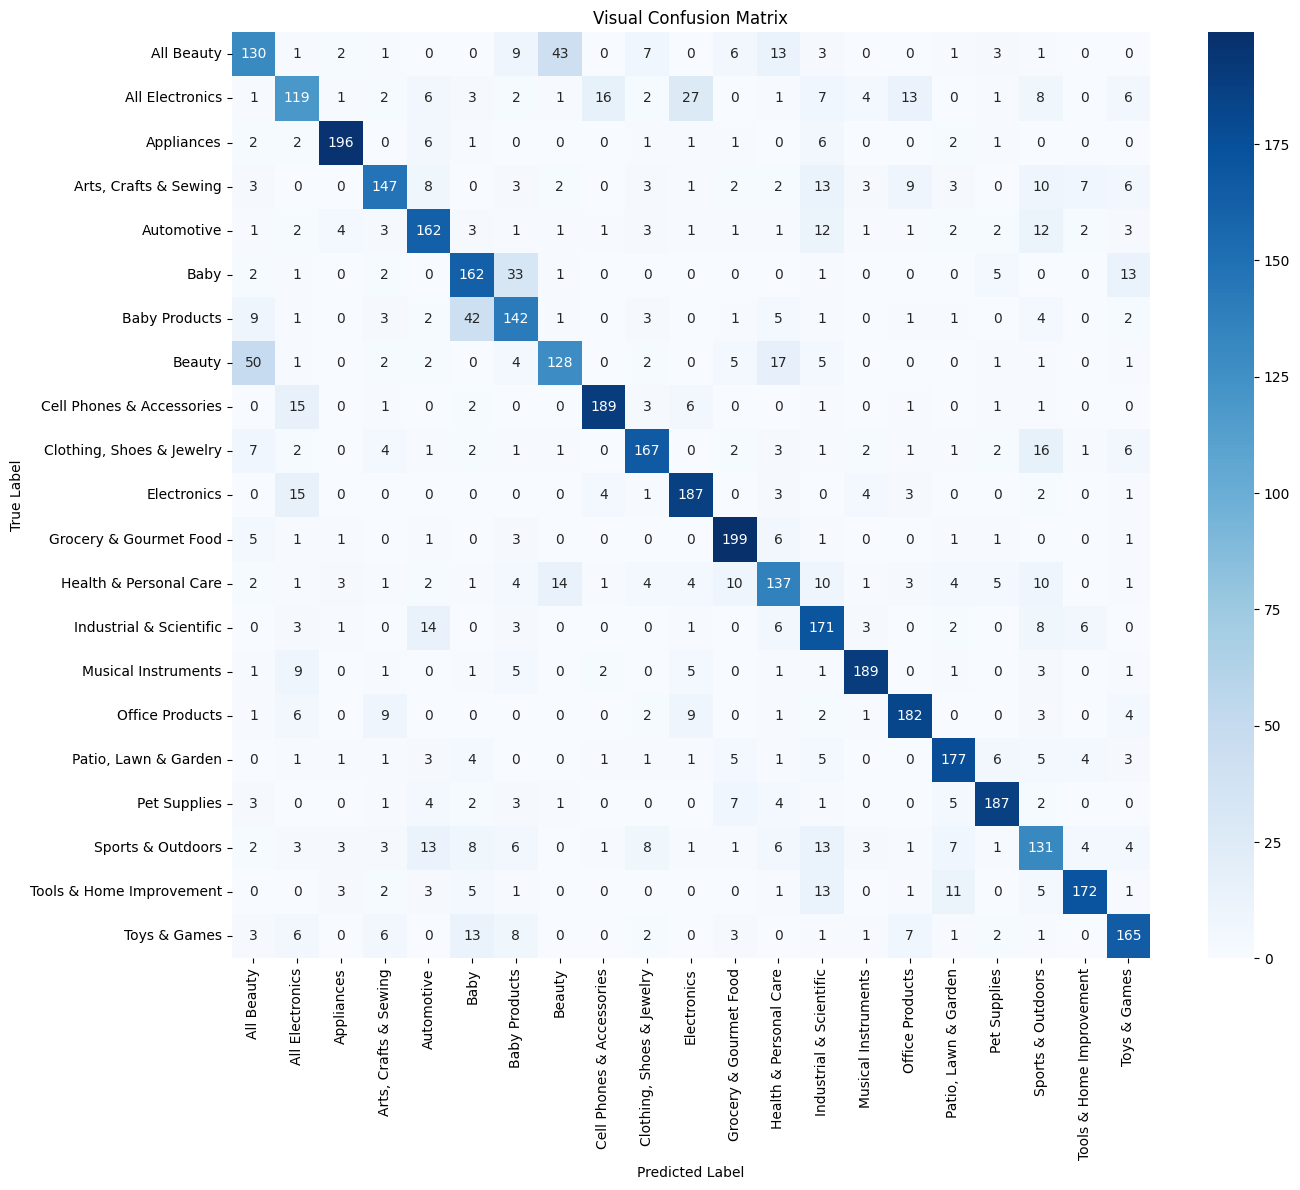


--- Plotting Multi-Class ROC Curve ---


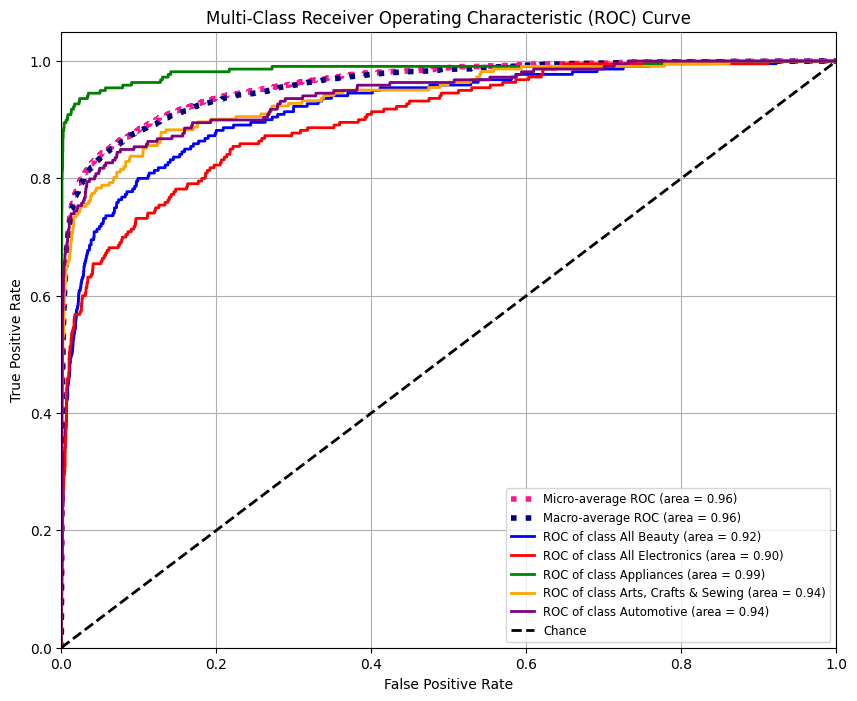


Model saved successfully as 'retail_category_classifier_multimodal.h5'.


In [9]:
# --- 6. Evaluation and Metrics ---
import matplotlib.pyplot as plt
import seaborn as sns
print("\n--- Evaluating on Test Set ---")

# Evaluate the model
loss, accuracy = multimodal_model.evaluate(test_dataset, verbose=1)
print(f"\nOverall Test Accuracy: {accuracy*100:.2f}%")
print(f"Overall Test Loss: {loss:.4f}")

# Generate predictions for detailed metrics
# The dataset yields ([X_img, X_text], y_true)
y_pred_probs = multimodal_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels from the dataset (y_true is needed for sklearn metrics)
y_true_list = []
for _, y_batch in test_dataset:
    y_true_list.append(y_batch.numpy())

y_true_one_hot = np.concatenate(y_true_list)
y_true = np.argmax(y_true_one_hot, axis=1)

# Ensure the lengths match (which they should with tf.data.Dataset)
if len(y_true) != len(y_pred):
    print("Warning: Length mismatch between true and predicted labels. Adjusting.")
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    y_pred_probs = y_pred_probs[:min_len] # Also adjust prediction probabilities

# --- GENERATE PLOTS AND REPORTS ---

# 1. Accuracy and Loss Curve
print("\n--- Plotting Training History (Accuracy and Loss Curve) ---")
plot_training_history(history)

# 2. Classification Report (Text)
print("\n--- Classification Report (Per-Class Metrics) ---")
# Use target_names for readability
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

# 3. Visual Confusion Matrix
print("\n--- Plotting Visual Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, CLASS_NAMES)

# 4. ROC Curve
print("\n--- Plotting Multi-Class ROC Curve ---")
plot_multiclass_roc(y_true, y_pred_probs, CLASS_NAMES, NUM_CLASSES)


# Save the model
multimodal_model.save('retail_category_classifier_multimodal.h5')
print("\nModel saved successfully as 'retail_category_classifier_multimodal.h5'.")
